In [1]:
# 0. Imports & configuration

import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# For reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# CIFAR-10 class names
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


In [2]:
# 1. Load and preprocess CIFAR-10 data

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

# Normalise to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

print("Train shape:", x_train.shape, y_train.shape)
print("Test shape:", x_test.shape, y_test.shape)

# Train/validation split
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

print("New train shape:", x_train.shape, y_train.shape)
print("Validation shape:", x_val.shape, y_val.shape)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Validation and test: only rescale
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train, y_train, batch_size=64, shuffle=True)
val_generator   = test_datagen.flow(x_val, y_val, batch_size=64, shuffle=False)
test_generator  = test_datagen.flow(x_test, y_test, batch_size=64, shuffle=False)


Train shape: (50000, 32, 32, 3) (50000,)
Test shape: (10000, 32, 32, 3) (10000,)
New train shape: (40000, 32, 32, 3) (40000,)
Validation shape: (10000, 32, 32, 3) (10000,)


In [3]:
# 2. Define CNN model architecture

def build_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="cifar10_cnn")
    return model

model = build_cnn_model()
model.summary()


Model: "cifar10_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,57

 Total params: 668,842 (2.55 MB)

 Trainable params: 667,690 (2.55 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [4]:
# 3. Compile and train the model with callbacks

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    "cnn_cifar10_best.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)


Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3193 - loss: 2.2014
Epoch 1: val_accuracy improved from None to 0.54350, saving model to cnn_cifar10_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 78ms/step - accuracy: 0.3897 - loss: 1.8162 - val_accuracy: 0.5435 - val_loss: 1.2916 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5257 - loss: 1.3263
Epoch 2: val_accuracy improved from 0.54350 to 0.62230, saving model to cnn_cifar10_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.5451 - loss: 1.2700 - val_accuracy: 0.6223 - val_loss: 1.0900 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5984 - loss: 1.1317
Epoch 3: val_accuracy did not improve from 0.62230
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.6083 - loss: 1.1036 - val_accuracy: 0.5638 - val_loss: 1.3289 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6359 

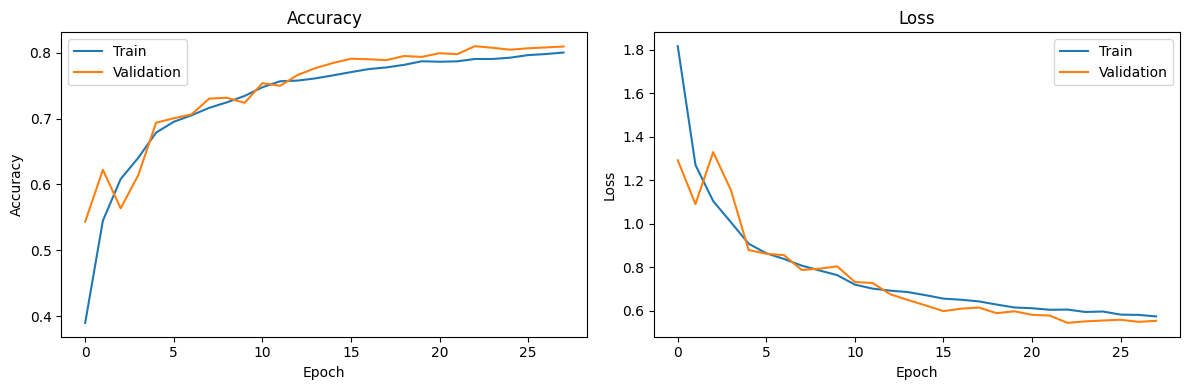

In [5]:
# 4. Plot training & validation accuracy and loss

def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train')
    axes[0].plot(history.history['val_accuracy'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    # Loss
    axes[1].plot(history.history['loss'], label='Train')
    axes[1].plot(history.history['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


✅ Test accuracy: 0.803
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step

Classification report:
              precision    recall  f1-score   support

    airplane       0.82      0.84      0.83      1000
  automobile       0.92      0.93      0.92      1000
        bird       0.83      0.66      0.74      1000
         cat       0.72      0.56      0.63      1000
        deer       0.76      0.78      0.77      1000
         dog       0.83      0.65      0.73      1000
        frog       0.63      0.96      0.76      1000
       horse       0.89      0.81      0.85      1000
        ship       0.88      0.91      0.89      1000
       truck       0.83      0.93      0.88      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



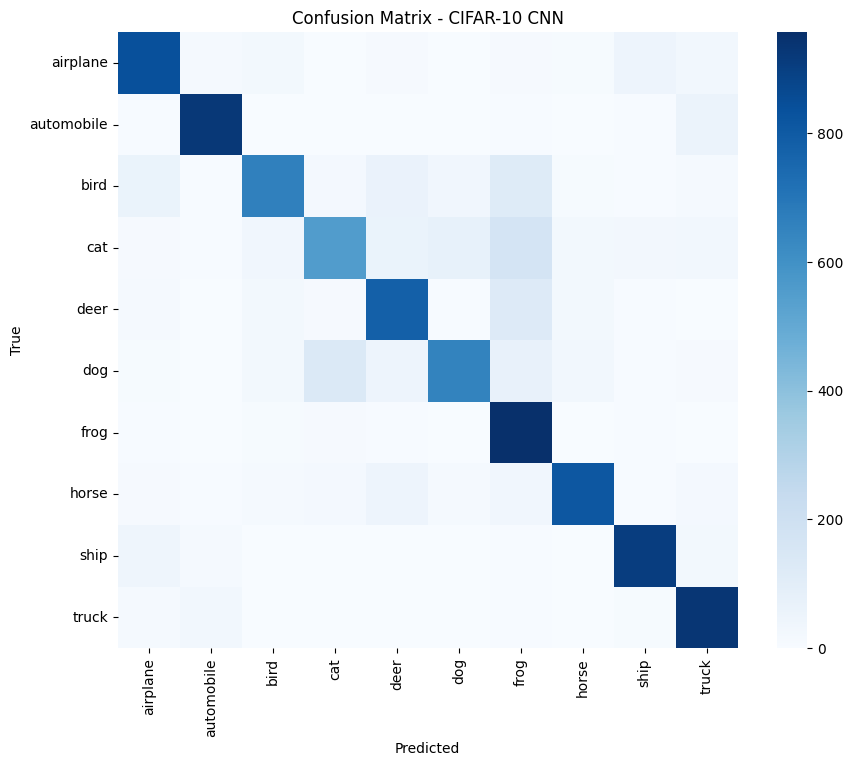

In [6]:
# 5. Evaluate on test set with detailed metrics

test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"✅ Test accuracy: {test_acc:.3f}")

# Predict on the full test set
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CIFAR-10 CNN")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


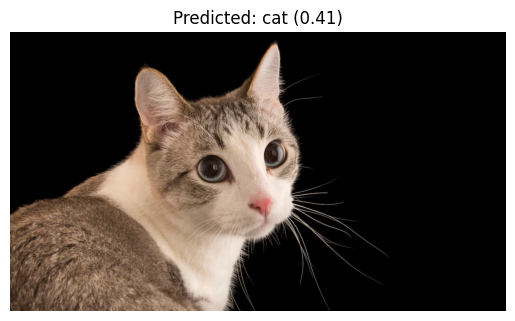

Predicted label: cat, confidence: 0.41


In [7]:
# 6. Single-image prediction (e.g. cat.jpg)

from tensorflow.keras.preprocessing import image

def predict_image(path, model, class_names=CLASS_NAMES):
    img = image.load_img(path, target_size=(32, 32))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    class_idx = np.argmax(preds[0])
    confidence = preds[0][class_idx]

    plt.imshow(image.load_img(path))
    plt.axis("off")
    plt.title(f"Predicted: {class_names[class_idx]} ({confidence:.2f})")
    plt.show()

    return class_names[class_idx], float(confidence)

pred_label, conf = predict_image("cat.jpg", model)
print(f"Predicted label: {pred_label}, confidence: {conf:.2f}")
